In [1]:
from PIL import Image, ImageOps, ImageEnhance, ImageFilter, ImageDraw
from PIL.ExifTags import TAGS
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

shared_kw = dict(figsize=[18,18/1.5/2],sharex=True,sharey=True,gridspec_kw=dict(hspace=0,wspace=0.01))
oneimg_kw = dict(figsize=[14,14/1.5])

# **Image processing for sediment transport (1/3)**

In [2]:
PATH_TO_MAGICK = r"/home/edwin/Apps/ImageMagick/magick"

In [3]:
raw_paths = {'left':r"/home/edwin/Pictures/Smol/SmolLeft/DSC_0930.JPG",
             'right':r"/home/edwin/Pictures/Smol/SmolRight/DSC_0930.JPG"}
## Open images
raw_imgs  = {k:Image.open(v) for k,v in raw_paths.items()}

## Read their datestamp
raw_imgs_timestamps = {k:v.getexif().get(306) for k,v in raw_imgs.items()}

## Show photos side to side

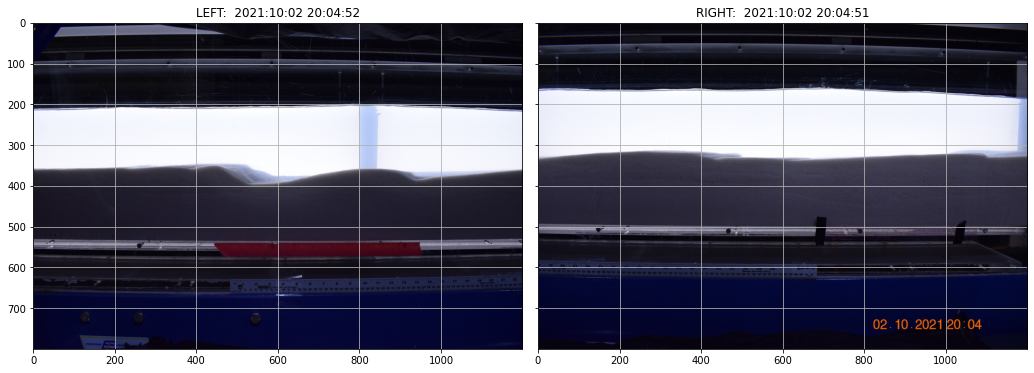

In [4]:
fig,axs = plt.subplots(1,2,**shared_kw)
for ax,k in zip(axs,raw_imgs.keys()):
    ax.imshow(raw_imgs[k])
    ax.set_title(f"{k.upper()}:  {raw_imgs_timestamps[k]}")
    ax.grid()
plt.show()

## Barrel Corrections

In [5]:
BARREL_PARAMS  = (0.000, -0.015, 0.000)

def fixBarrelDistortion(imgPath,params):
    a,b,c = params
    pathOut = imgPath.replace(".JPG","_barrel.JPG")
    os.system(PATH_TO_MAGICK + " convert \
               {0:} -virtual-pixel black -distort Barrel \
               \"{1:.4f} {2:.4f} {3:.4f}\" {4:}".format(imgPath,a,b,c,pathOut))
    return pathOut

In [6]:
barr_paths = {k:fixBarrelDistortion(v,BARREL_PARAMS) for k,v in raw_paths.items()} 
barr_imgs  = {k:Image.open(v) for k,v in barr_paths.items()}

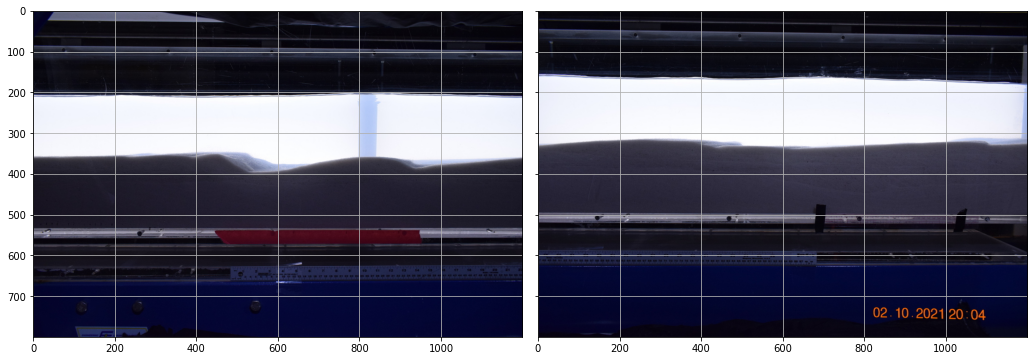

In [7]:
fig,axs = plt.subplots(1,2,**shared_kw)
axs[0].imshow(barr_imgs['left'])
axs[1].imshow(barr_imgs['right'])
for ax in axs: ax.grid()
plt.show()

## Perspective Correction

In [8]:
PERS_ORIGIN_LEFT  = {'x':[0,1162,1162,0]  ,'y':[533,532,99,87]}
PERS_ORIGIN_RIGHT = {'x':[84,1200,1200,84],'y':[495,500,64,49]}
PERS_TARGET_LEFT  = {'x':[0,1162,1162,0]  ,'y':[515,515,75,75]}
PERS_TARGET_RIGHT = {'x':[84,1200,1200,84],'y':[515,515,75,75]}

def fixPerspective(imgPath,pointsFrom,pointsTarget):
    
    originPairs = list(zip(pointsFrom['x'],pointsFrom['y']))
    targetPairs = list(zip(pointsTarget['x'],pointsTarget['y']))
    
    pathOut = imgPath.replace(".JPG","_perspective.JPG")
    
    listCoords = ""
    for o,t in zip(originPairs,targetPairs):
        listCoords += f"{o[0]},{o[1]} {t[0]},{t[1]}  "
    
    os.system(PATH_TO_MAGICK + " convert \
               {0:} -matte -virtual-pixel black -distort Perspective \
               '{1:}' {2:}".format(imgPath,listCoords,pathOut))
    return pathOut

In [9]:
pers_paths = {}
pers_paths['left']  = fixPerspective(barr_paths['left'],\
                                     PERS_ORIGIN_LEFT,PERS_TARGET_LEFT)
pers_paths['right'] = fixPerspective(barr_paths['right'],\
                                     PERS_ORIGIN_RIGHT,PERS_TARGET_RIGHT)
pers_imgs  = {k:Image.open(v) for k,v in pers_paths.items()}

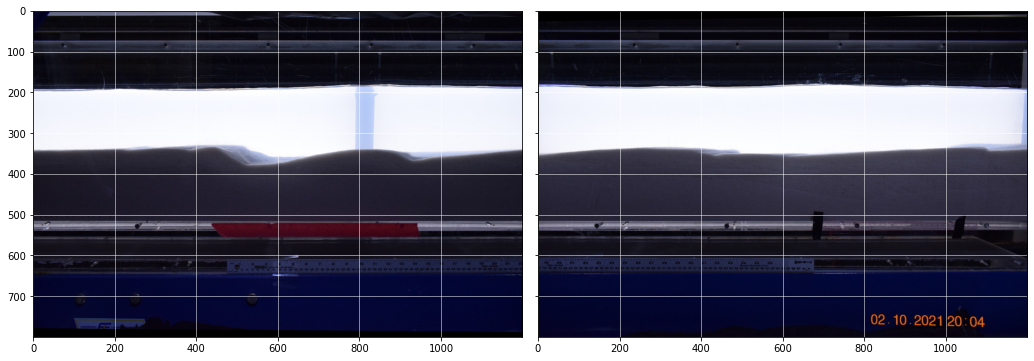

In [10]:
fig,axs = plt.subplots(1,2,**shared_kw)
axs[0].imshow(pers_imgs['left'])
axs[1].imshow(pers_imgs['right'])
for ax in axs: ax.grid(which='both',lw=0.5,color='w')
plt.show()

## Crop pictures

In [11]:
crop_imgs  = {k:v.crop((0, 250, v.size[0], 500)) for k,v in pers_imgs.items()}

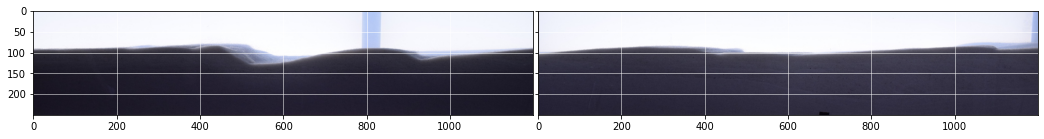

In [12]:
fig,axs = plt.subplots(1,2,**shared_kw)
axs[0].imshow(crop_imgs['left'])
axs[1].imshow(crop_imgs['right'])
for ax in axs: ax.grid(which='both',lw=0.5,color='w')
plt.show()

## Equalize pictures

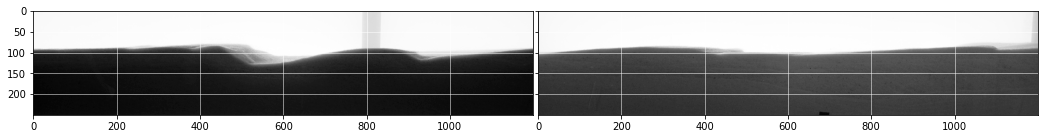

In [13]:
np_imgs   = {k:np.asarray(v.convert('L')) for k,v in crop_imgs.items()}
equa_imgs = {k:np.interp(v, (v.min(), v.max()), (0, 255)) for k,v in np_imgs.items()}
inte_imgs = {k:Image.fromarray(v.astype(np.uint8),"L") for k,v in equa_imgs.items()}

fig,axs = plt.subplots(1,2,**shared_kw)
axs[0].imshow(inte_imgs['left'],cmap='Greys_r')
axs[1].imshow(inte_imgs['right'],cmap='Greys_r')
for ax in axs: ax.grid(which='both',lw=0.5,color='w')
plt.show()

## Overlap

In [14]:
XSHIFT = 1162 - 84 # Overlap between pictures
x, y = np.meshgrid(np.arange(inte_imgs['left'].width),np.arange(inte_imgs['left'].height,0,-1))

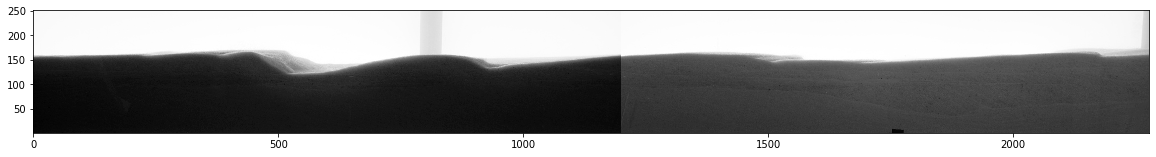

In [15]:
fig,ax= plt.subplots(1,1,figsize=[20,6])
ax.pcolormesh(x+XSHIFT,y,equa_imgs['right'],cmap='Greys_r',shading='nearest',zorder=1)
ax.pcolormesh(x,y,equa_imgs['left'],cmap='Greys_r',shading='nearest',alpha=1,zorder=2)
ax.set_aspect('equal')
plt.show()

## Save merged image into a single one

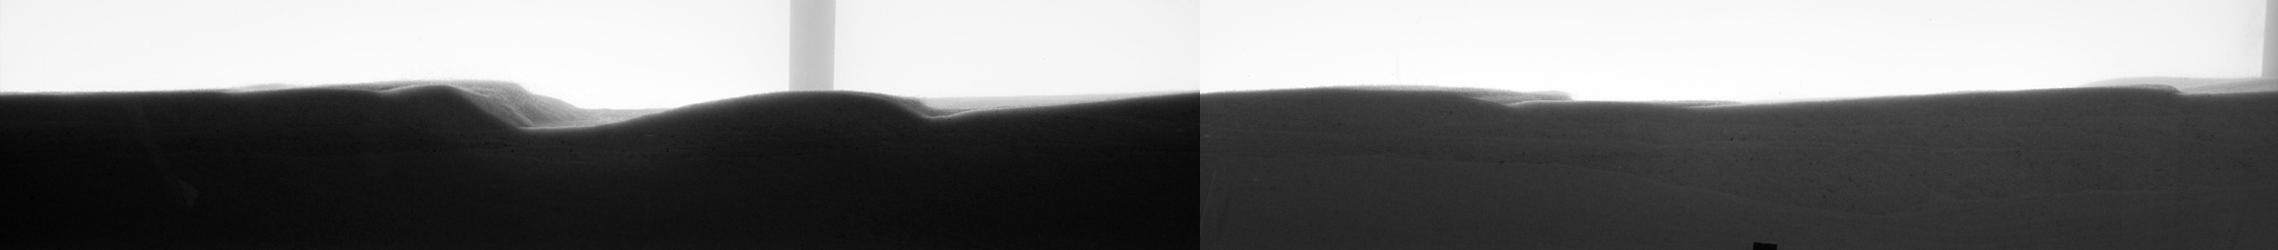

In [16]:
(width1, height1) = inte_imgs['left'].size
(width2, height2) = inte_imgs['right'].size

result_width = width1 + XSHIFT
result_height = max(height1, height2)

joined_img = Image.new('L', (result_width, result_height))
joined_img.paste(im=inte_imgs['right'], box=(XSHIFT, 0))
joined_img.paste(im=inte_imgs['left'], box=(0, 0))
joined_img

________________
## Color classification

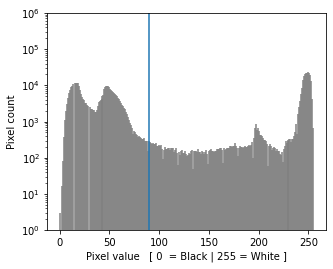

In [17]:
MASKING_THRESHOLD = 90

hits = joined_img.histogram()
fig,axs = plt.subplots(1,1,figsize=[5,4],sharex=True,sharey=True,gridspec_kw={'wspace':0.01})
axs.vlines(np.arange(len(hits)),np.ones_like(hits),hits,color='grey')
axs.axvline(x=MASKING_THRESHOLD)
axs.set(ylim=[1,1.0E6],yscale='log')
axs.set(ylabel = "Pixel count", xlabel="Pixel value   [ 0  = Black | 255 = White ]")
plt.show()

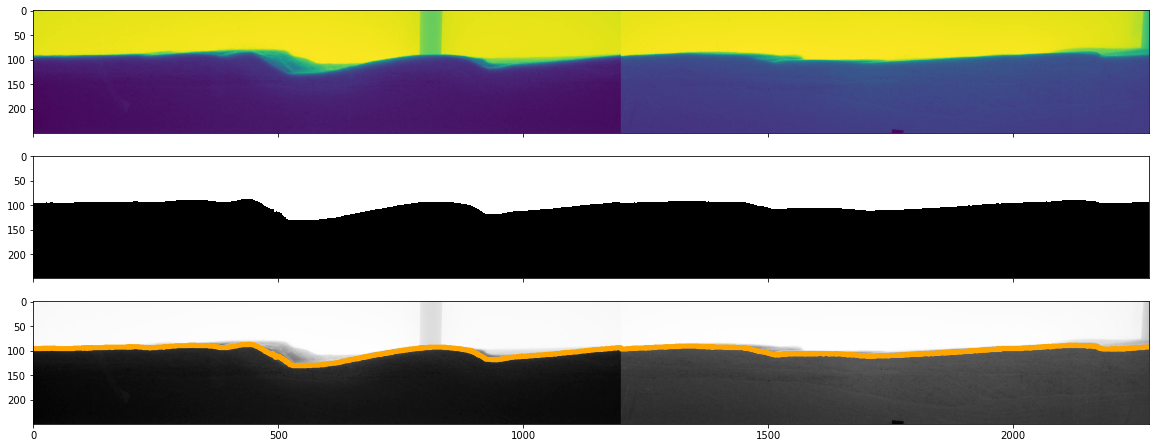

In [18]:
masked = np.ma.masked_greater(joined_img,MASKING_THRESHOLD)
ycoord = np.ma.count_masked(masked,axis=0)
masked[np.logical_not(masked.mask)] = 1

fig,axs = plt.subplots(3,1,figsize=[20,8],sharex=True,gridspec_kw={'hspace':0.01})
axs[0].imshow(joined_img,alpha=1.0)
axs[1].imshow(masked,cmap='Greys_r')
axs[2].imshow(joined_img,cmap='Greys_r')
axs[2].plot(ycoord,c='orange',lw=5)
plt.show()

------
## Filtering and smoothing

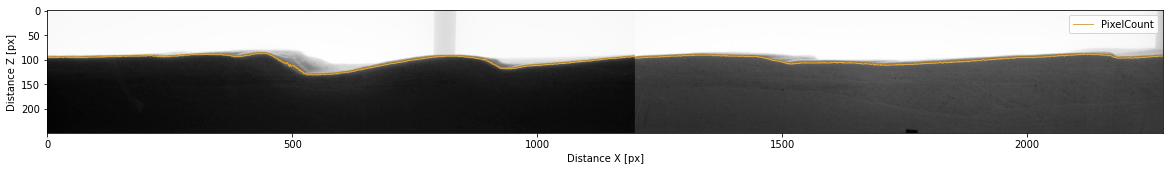

In [19]:
fig,ax = plt.subplots(1,1,figsize=[20,8])
ax.plot(np.arange(len(ycoord)),ycoord,lw=1,c='orange',label='PixelCount')
ax.set(xlabel="Distance X [px]",ylabel="Distance Z [px]")
ax.imshow(joined_img,cmap='Greys_r')
ax.legend()
plt.show()

In [20]:
from scipy.signal import savgol_filter

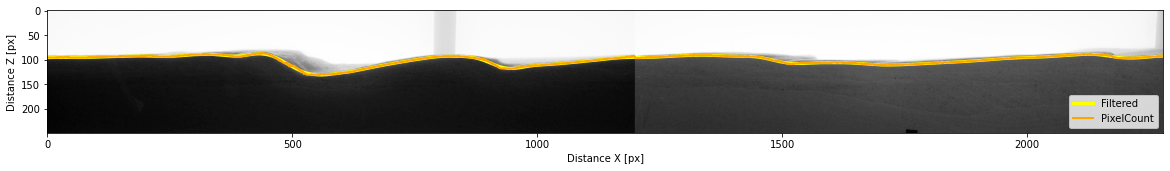

In [21]:
SAVGOL_FILTER_PARAMS = dict(window_length=171,polyorder=4)
ysmoothed = savgol_filter(ycoord,**SAVGOL_FILTER_PARAMS)

fig,ax = plt.subplots(1,1,figsize=[20,8])
xtemp = np.arange(len(ysmoothed))
ax.plot(xtemp,ysmoothed,lw=3,c='yellow',label='Filtered',zorder=2)
ax.plot(xtemp,ycoord,lw=2,c='orange',label='PixelCount')
ax.imshow(joined_img,cmap='Greys_r',zorder=1)
ax.set(xlabel="Distance X [px]",ylabel="Distance Z [px]")
ax.legend(loc='lower right')
plt.show()

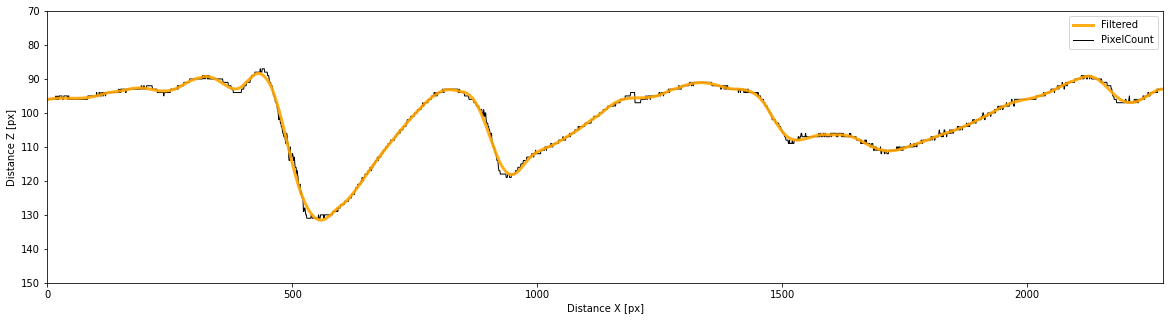

In [22]:
fig,ax = plt.subplots(1,1,figsize=[20,5])
xtemp = np.arange(len(ysmoothed))
ax.plot(xtemp,ysmoothed,lw=3,c='orange',alpha=0.9,label='Filtered',zorder=2)
ax.plot(xtemp,ycoord,lw=1,c='k',label='PixelCount',zorder=1)
ax.set(xlabel="Distance X [px]",ylabel="Distance Z [px]",ylim=[150,70],xlim=[0,joined_img.width])
ax.legend()
plt.show()

## Peak and trough identification

In [23]:
from scipy.signal import find_peaks

In [24]:
TROUGH_FINDER_PARAMS = dict(distance=200,height=15,prominence=10)
PEAK_FINDER_PARAMS   = dict(distance=200,prominence=10)

whereTroughs,_ = find_peaks(ysmoothed,**TROUGH_FINDER_PARAMS)
Troughs_df = pd.DataFrame({'X':whereTroughs,'ZT':[ysmoothed[w] for w in whereTroughs]})
Troughs_df.set_index('X',inplace=True)

wherePeaks,_ = find_peaks(-ysmoothed,**PEAK_FINDER_PARAMS)
Peaks_df = pd.DataFrame({'X':wherePeaks,'ZP':[ysmoothed[w] for w in wherePeaks]})
Peaks_df.set_index('X',inplace=True)

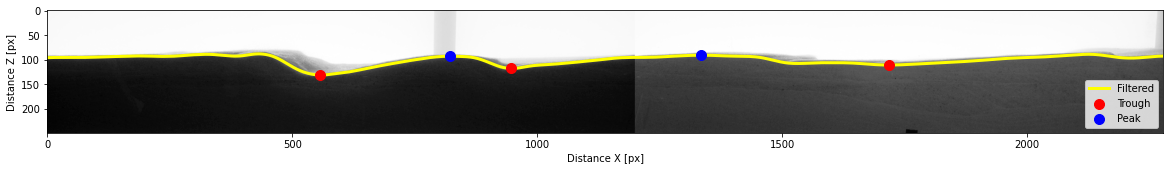

In [25]:
fig,ax = plt.subplots(1,1,figsize=[20,8])
ax.plot(xtemp,ysmoothed,lw=3,c='yellow',label='Filtered',zorder=2)
ax.scatter(Troughs_df.index,Troughs_df['ZT'],c='r',s=100,zorder=3,label='Trough')
ax.scatter(Peaks_df.index,Peaks_df['ZP'],c='b',s=100,zorder=3,label='Peak')
ax.imshow(joined_img,cmap='Greys_r',zorder=1)
ax.set(xlabel="Distance X [px]",ylabel="Distance Z [px]")
ax.legend(loc='lower right')
plt.show()

### Check only features

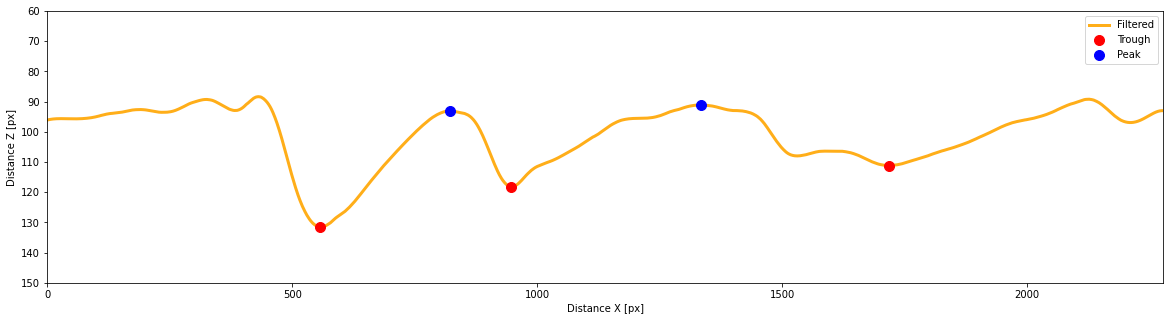

In [26]:
fig,ax = plt.subplots(1,1,figsize=[20,5])
ax.plot(xtemp,ysmoothed,lw=3,c='orange',alpha=0.9,label='Filtered',zorder=2)
ax.scatter(Troughs_df.index,Troughs_df['ZT'],c='r',s=100,zorder=3,label='Trough')
ax.scatter(Peaks_df.index,Peaks_df['ZP'],c='b',s=100,zorder=3,label='Peak')
ax.set(xlabel="Distance X [px]",ylabel="Distance Z [px]",ylim=[150,60],xlim=[0,joined_img.width])
ax.legend()
plt.show()

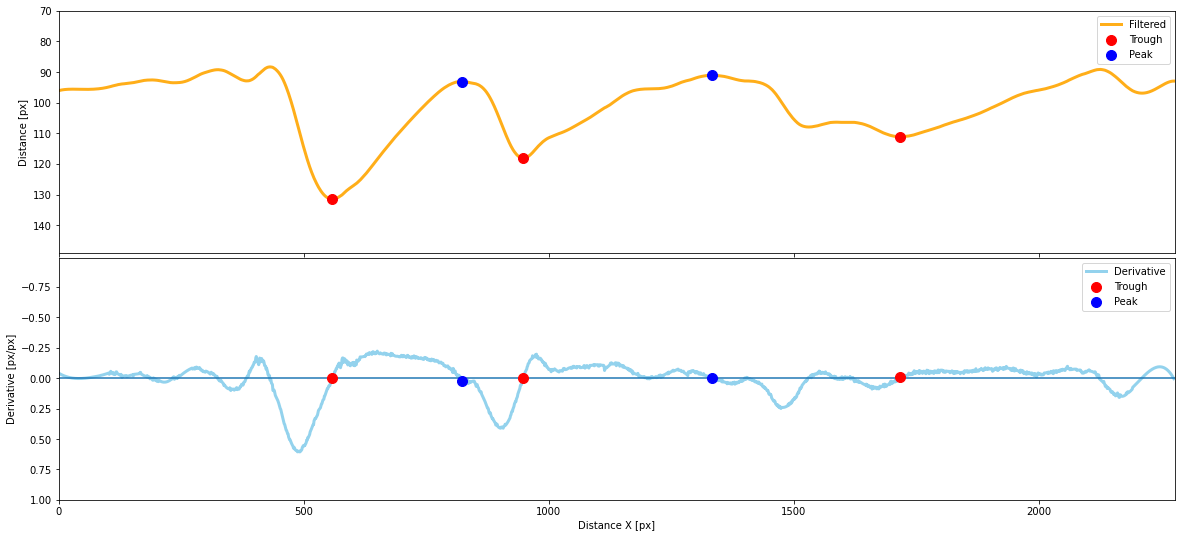

In [27]:
yderiv = np.diff(ysmoothed)

fig,axs = plt.subplots(2,1,figsize=[20,9],sharex=True,gridspec_kw={'hspace':0.02})
ax=axs[0]
ax.plot(xtemp,ysmoothed,lw=3,c='orange',alpha=0.9,label='Filtered',zorder=1)
ax.set(ylabel="Distance [px]",ylim=[149,70],xlim=[0,joined_img.width])
ax.scatter(Troughs_df.index,Troughs_df['ZT'],c='r',s=100,zorder=3,label='Trough')
ax.scatter(Peaks_df.index,Peaks_df['ZP'],c='b',s=100,zorder=3,label='Peak')
ax.legend()

ax=axs[1]
ax.plot(np.arange(len(yderiv)),yderiv,lw=3,c='skyblue',alpha=0.9,label='Derivative',zorder=2)
ax.axhline(y=0)
ax.scatter(Troughs_df.index,[yderiv[i] for i in Troughs_df.index],c='r',s=100,zorder=3,label='Trough')
ax.scatter(Peaks_df.index,[yderiv[i] for i in Peaks_df.index],c='b',s=100,zorder=3,label='Peak')
ax.set(xlabel="Distance X [px]",ylabel="Derivative [px/px]",ylim=[1,-.99],xlim=[0,joined_img.width])
ax.legend()
plt.show()

_____

## Final results

In [28]:
## create annotations over image
endimg = Image.new('RGB', joined_img.size)
endimg.paste(im=joined_img, box=(0, 0))

lineimg = ImageDraw.Draw(endimg)
lineimg.line(list(zip(np.arange(joined_img.size[0]),ysmoothed)), fill ="orange", width = 7)

r = 10
for wt in whereTroughs:
    lineimg.ellipse([(wt-r,ysmoothed[wt]-r),(wt+r,ysmoothed[wt]+r)],
                    outline = 'white', fill = 'red', width = 1)

for wt in wherePeaks:
    lineimg.ellipse([(wt-r,ysmoothed[wt]-r),(wt+r,ysmoothed[wt]+r)], 
                    outline = 'white', fill = 'blue', width = 1)

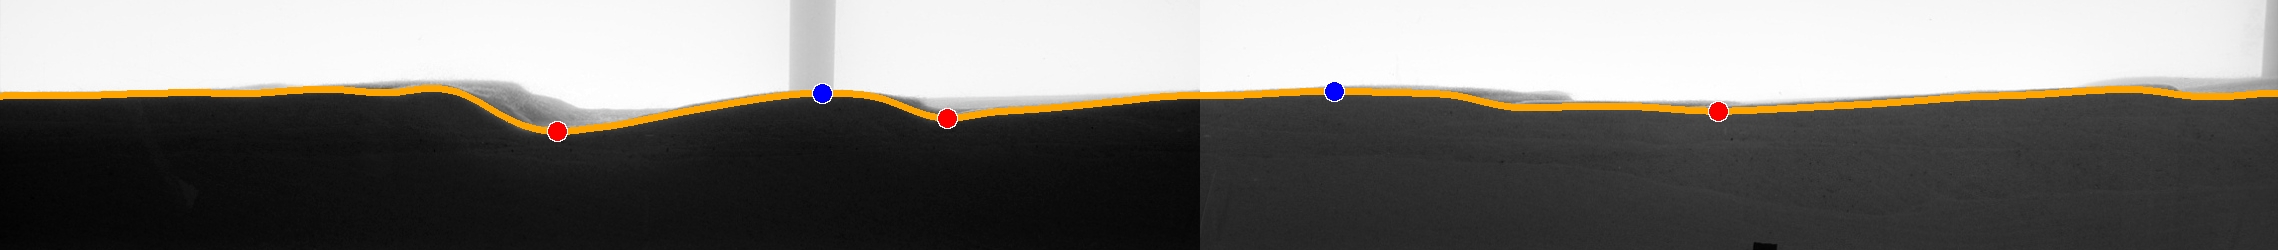

In [29]:
endimg

In [30]:
Troughs_df

,ZT
X,
557,131.555762
947,118.151095
1718,111.194184


In [31]:
Peaks_df

,ZP
X,
822,93.141150
1334,91.073749


## Remove temporal files

In [32]:
for f in barr_paths.values(): os.remove(f) 
for f in pers_paths.values(): os.remove(f)